In [1]:
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
#from sklearn.metrics import f1_score
#from tensorflow.keras.callbacks import TensorBoard
import pickle
import numpy as np
import time
from tensorflow.keras.callbacks import EarlyStopping

import matplotlib.pyplot as plt

X = pickle.load(open("Xtrain.pickle","rb"))
y = pickle.load(open("Ytrain.pickle","rb"))

x_test = pickle.load(open('Xtest_unb.pickle','rb'))
y_test = pickle.load(open('Ytest_unb.pickle','rb'))

#dense_layers = [0, 1, 2]
#layer_sizes = [32, 64, 128]
#conv_layers = [1,2,3]





In [2]:
import matplotlib.pyplot as plt

#from keras.callbacks import Callback


class LRFinder(tf.keras.callbacks.Callback):
    
    # found here https://gist.github.com/jeremyjordan/ac0229abd4b2b7000aca1643e88e0f02
    
    '''
    A simple callback for finding the optimal learning rate range for your model + dataset. 
    
    # Usage
        ```python
            lr_finder = LRFinder(min_lr=1e-5, 
                                 max_lr=1e-2, 
                                 steps_per_epoch=np.ceil(epoch_size/batch_size), 
                                 epochs=3)
            model.fit(X_train, Y_train, callbacks=[lr_finder])
            
            lr_finder.plot_loss()
        ```
    
    # Arguments
        min_lr: The lower bound of the learning rate range for the experiment.
        max_lr: The upper bound of the learning rate range for the experiment.
        steps_per_epoch: Number of mini-batches in the dataset. Calculated as `np.ceil(epoch_size/batch_size)`. 
        epochs: Number of epochs to run experiment. Usually between 2 and 4 epochs is sufficient. 
        
    # References
        Blog post: jeremyjordan.me/nn-learning-rate
        Original paper: https://arxiv.org/abs/1506.01186
    '''
    
    def __init__(self, min_lr=1e-5, max_lr=1e-2, steps_per_epoch=None, epochs=None):
        super(LRFinder, self).__init__()
        
        self.min_lr = min_lr
        self.max_lr = max_lr
        self.total_iterations = steps_per_epoch * epochs
        self.iteration = 0
        self.history = {}
        
    def clr(self):
        '''Calculate the learning rate.'''
        x = self.iteration / self.total_iterations 
        return self.min_lr + (self.max_lr-self.min_lr) * x
        
    def on_train_begin(self, logs=None):
        '''Initialize the learning rate to the minimum value at the start of training.'''
        logs = logs or {}
        K.set_value(self.model.optimizer.lr, self.min_lr)
        
    def on_batch_end(self, epoch, logs=None):
        '''Record previous batch statistics and update the learning rate.'''
        logs = logs or {}
        self.iteration += 1

        self.history.setdefault('lr', []).append(K.get_value(self.model.optimizer.lr))
        self.history.setdefault('iterations', []).append(self.iteration)

        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)
            
        K.set_value(self.model.optimizer.lr, self.clr())
 
    def plot_lr(self):
        '''Helper function to quickly inspect the learning rate schedule.'''
        plt.plot(self.history['iterations'], self.history['lr'])
        plt.yscale('log')
        plt.xlabel('Iteration')
        plt.ylabel('Learning rate')
        plt.show()
        
    def plot_loss(self):
        '''Helper function to quickly observe the learning rate experiment results.'''
        plt.plot(self.history['lr'], self.history['loss'])
        plt.xscale('log')
        plt.xlabel('Learning rate')
        plt.ylabel('Loss')
        plt.show()

26886/26886 [==============================] - 3s 127us/sample - loss: 0.5414 - acc: 0.7405


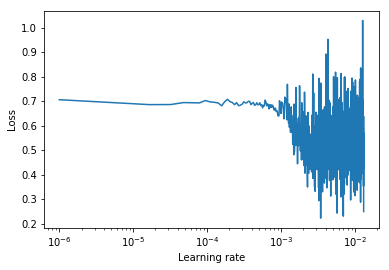

In [26]:
epoch_size=1280
batch_size = 128
#num_classes = 10
#epochs = 5
    
layer_sizes = 128
dropout = [0.1]
    
model_lr = Sequential()
          
model_lr.add(Flatten(input_shape=X[0].shape))

model_lr.add(Dense(layer_sizes))
model_lr.add(Activation("relu"))
model_lr.add(Dropout(dropout[0]))

model_lr.add(Dense(layer_sizes))
model_lr.add(Activation("relu"))
model_lr.add(Dropout(dropout[0]))

model_lr.add(Dense(layer_sizes))
model_lr.add(Activation("relu"))
model_lr.add(Dropout(dropout[0]))

model_lr.add(Dense(layer_sizes))
model_lr.add(Activation("relu"))
model_lr.add(Dropout(dropout[0]))

model_lr.add(Dense(layer_sizes))
model_lr.add(Activation("relu"))
model_lr.add(Dropout(dropout[0]))


model_lr.add(Dense(1))
model_lr.add(Activation("sigmoid"))
    

model_lr.compile(loss="binary_crossentropy",
                  optimizer="adam",
                  metrics=['accuracy'])

lr_finder = LRFinder(min_lr=1e-6, 
                                 max_lr=1e-2, 
                                 #steps_per_epoch=np.ceil(epoch_size/batch_size),
                                 steps_per_epoch=80,
                                 epochs=8)

model_lr.fit(X,y, callbacks=[lr_finder])
            
lr_finder.plot_loss()

Restoring model weights from the end of the best epoch.
Epoch 00079: early stopping


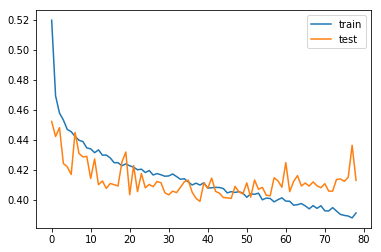

In [27]:

            
model = Sequential()
          
model.add(Flatten(input_shape=X[0].shape))

model.add(Dense(layer_sizes))
model.add(Activation("relu"))
model.add(Dropout(dropout[0]))

model.add(Dense(layer_sizes))
model.add(Activation("relu"))
model.add(Dropout(dropout[0]))

model.add(Dense(layer_sizes))
model.add(Activation("relu"))
model.add(Dropout(dropout[0]))

model.add(Dense(layer_sizes))
model.add(Activation("relu"))
model.add(Dropout(dropout[0]))

model.add(Dense(layer_sizes))
model.add(Activation("relu"))
model.add(Dropout(dropout[0]))


model.add(Dense(1))
model.add(Activation("sigmoid"))
            
opt=tf.keras.optimizers.Adam()    
    
model.compile(loss = "binary_crossentropy",
                          optimizer = opt,
                          metrics = ['accuracy'])
            
es = EarlyStopping(monitor='val_loss', mode='min', patience=25, verbose=1, restore_best_weights=True)           

history = model.fit(X,y, batch_size = 32, epochs =180,verbose=0,validation_split = 0.2,callbacks=[es])

# plot training history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [28]:
val_loss, val_acc = model.evaluate(x_test, y_test) # evaluate the out of sample data with model
print(val_loss) # model's loss (error)
print(val_acc) # model's accuracy

13353/13353 [==============================] - 0s 29us/sample - loss: 0.4109 - acc: 0.8173
0.41087759045177763
0.8172695


In [22]:
def f1(y_true, y_pred):
    y_pred = K.round(y_pred)
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
    # tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=0)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2*p*r / (p+r+K.epsilon())
    f1 = tf.where(tf.is_nan(f1), tf.zeros_like(f1), f1)
    return K.mean(f1)

In [29]:
predict_2 = model.predict(x_test)
predict_2

array([[0.34058905],
       [0.09668127],
       [0.10923091],
       ...,
       [0.2540418 ],
       [0.9506937 ],
       [0.10458539]], dtype=float32)

In [54]:
threshold = 0.6395
predict_3=predict_2>=threshold
predict_3=predict_3*1
predict_3

array([[0],
       [0],
       [0],
       ...,
       [0],
       [1],
       [0]])

In [55]:
#print('sklearn Macro-F1-Score:', f1_score(y_test, model.predict_class(x_test), average='macro'))
print('Custom Macro-F1-Score:', K.eval(f1(y_test, np.reshape(predict_3,(-1)))))


Custom Macro-F1-Score: 0.7233185


In [10]:
model.save('first_Dense_V5_2_1.model') # save the model

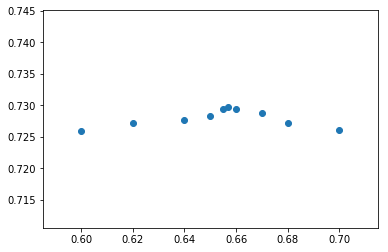

In [11]:
threshold_ratio = np.array([#[0.3, 0.64159465],
                  # [0.4  , 0.6857272],
                   #[0.5  , 0.71317065],
                   [0.6  , 0.7258737],
                   [0.62 , 0.7271045],
                   [0.64 , 0.7276379] ,
                   [0.65 , 0.7282285],
                   [0.655 , 0.72941166], 
                   [0.657 , 0.7296857], 
                   [0.66 , 0.7293957],
                   [0.67 , 0.72881585],
                   [0.68 , 0.72712207],
                   [0.7  , 0.7259926],
                   #[0.8  , 0.675983],
                   #[0.9  , 0.48307756]
                           ])
threshold_ratio[:,0]

plt.scatter(threshold_ratio[:,0],threshold_ratio[:,1])

balanced  test data: 
0.5 - 0.832426

unbalanced test data (same ratio as upload):

0.3  - 0.64159465
0.4  - 0.6857272
0.5  - 0.71317065
0.6  - 0.7258737
0.65 - 0.7282285
0.66 - 0.7293957
0.67 - 0.72881585
0.68 - 0.72712207
0.7  - 0.7259926
0.8  - 0.675983
0.9  - 0.48307756